# Inagaki et al., 2018 & 2019 - A DataJoint example
This notebook presents data and results associated with the following papers:
>Hidehiko K. Inagaki, Lorenzo Fontolan, Sandro Romani & Karel Svoboda. "Discrete attractor dynamics underlies persistent activity in the frontal cortex" (2019) Nature (https://doi.org/10.1038/s41586-019-0919-7)


>Hidehiko K. Inagaki, Miho Inagaki, Sandro Romani and Karel Svoboda. "Low-Dimensional and Monotonic Preparatory Activity in Mouse Anterior Lateral Motor Cortex" (2018) Jneurosci (https://doi.org/10.1523/JNEUROSCI.3152-17.2018)

A ***DataJoint*** data pipeline has been constructed for this study, with the presented data ingested into this pipeline. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. From the pipeline, export capability to NWB 2.0 format is also available.

## About the data
The dataset comprises of whole-cell recordings, extracellular recordings and spike sorted results of the mouse's ALM during a delay-response task. The behavior data includes detailed description of the trial structure (e.g. trial timing, trial instruction, trial response, etc.) and the timing of the lick events (e.g. lick left, lick right onset). The data also includes detailed information regarding the optogenetic perturbations on a per-trial basis. 

The data in original MATLAB format (.mat) have been ingested into a DataJoint data pipeline presented below.

Data are also exported into NWB 2.0 format. The code used for performing NWB export can be found [here](../scripts/datajoint_to_nwb.py).

In [1]:
# import necessary Python packages including DataJoint

from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis,
                      intracellular, extracellular, behavior)

Connecting root@127.0.0.1:3306


## The architecture of this data pipeline
This data pipeline is comprised of three core components:

+ **subject**: the meta information on the animal, e.g. genetic information
+ **acquisition**: the organization of the experiment - session acquisition, trial structure, behavior data, photostimulation
+ **electrophysiology**: intracellular and extracellular recordings, as well as spike sorted results

In DataJoint, related tables are organized together into a **schema**, and a data pipeline typically consists of tables across multiple schemas connected to each other.

### Subject

`subject` schema contains various tables representing information and meta-information about the experimental animals, as well as information about genetic backgrounds and virus injected for the experiment. The DataJoint *Diagram* below shows all tables found inside the `subject` schema.

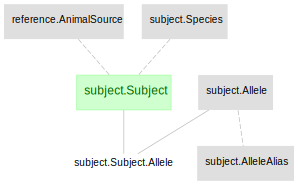

In [3]:
dj.Diagram(subject) - 1

For example, `Subject` table contains information about each and every mouse in the experiment, capturing information such as unique subject ID and animal sourcce.

In [4]:
subject.Subject()

subject_id id of the subject (e.g. ANM244028),species,"animal_source source of the animal, Jax, Charles River etc.",sex,date_of_birth,subject_description
anm284530,Mus musculus,N/A,U,2015-04-14,None
anm287242,Mus musculus,N/A,U,2014-12-30,None
anm287244,Mus musculus,N/A,U,2014-12-30,None
anm287245,Mus musculus,N/A,U,2014-12-30,None
anm290115,Mus musculus,N/A,U,2015-01-06,None
anm300476,Mus musculus,N/A,U,2015-03-28,None
anm301659,Mus musculus,N/A,U,2015-04-07,None


### Experiment acquisition

Information pertaining to conducting the experiment as well as data and meta-data acquired during the experiment (except for electrophysiology) are found among three schemas: `acquisition`, `stimulation` and `behavior`. Below, tables across all three schemas are depicted in the DataJoint Diagram.

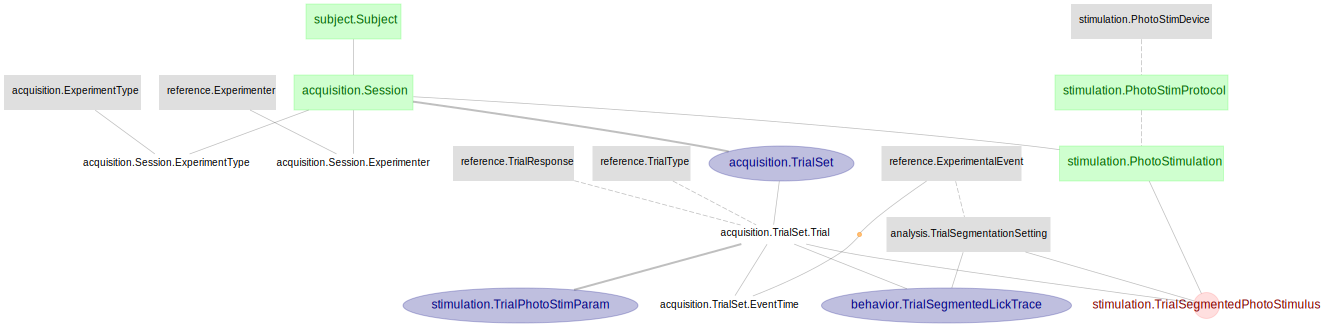

In [5]:
dj.Diagram(acquisition) - 1 + dj.Diagram(stimulation) + dj.Diagram(behavior)

`Session` tables contains information about individual experiment session.

In [6]:
acquisition.Session.proj() * subject.Subject

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,species,"animal_source source of the animal, Jax, Charles River etc.",sex,date_of_birth,subject_description
anm284530,2015-07-01 00:00:00,Whole_cell_105_regular,Mus musculus,N/A,U,2015-04-14,None
anm284530,2015-07-01 00:00:00,Whole_cell_106_regular,Mus musculus,N/A,U,2015-04-14,None
anm284530,2015-07-02 00:00:00,Whole_cell_108_regular,Mus musculus,N/A,U,2015-04-14,None
anm284530,2015-07-03 00:00:00,Whole_cell_109_regular,Mus musculus,N/A,U,2015-04-14,None
anm284530,2015-07-03 00:00:00,Whole_cell_110_regular,Mus musculus,N/A,U,2015-04-14,None
anm287242,2015-08-05 00:00:00,Whole_cell_131_regular,Mus musculus,N/A,U,2014-12-30,None
anm287242,2015-08-06 00:00:00,Whole_cell_133_regular,Mus musculus,N/A,U,2014-12-30,None


`Trial` table (found as part table of `TrialSet`) contains information about each trial.

In [7]:
acquisition.TrialSet.Trial * stimulation.TrialPhotoStimParam

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,trial_id id of this trial in this trial set,"start_time start time of this trial, with respect to starting point of this session","stop_time end time of this trial, with respect to starting point of this session",trial_type,trial_response,trial_stim_present is this a stim or no-stim trial,trial_is_good good/bad status of trial (bad trials are not analyzed),delay_duration (s) duration of the delay period,photo_stim_period,photo_stim_power (mW) stimulation power
anm319313,2016-01-05 00:00:00,HI72_010516,1,8e-05,6.00012,lick right,no response,0,0,1.20,early delay,nan
anm319313,2016-01-05 00:00:00,HI72_010516,2,6.0002,12.0002,lick left,correct,0,0,1.20,early delay,nan
anm319313,2016-01-05 00:00:00,HI72_010516,3,12.0003,18.0003,lick left,correct,0,1,1.20,early delay,nan
anm319313,2016-01-05 00:00:00,HI72_010516,4,18.0004,24.0004,lick right,incorrect,0,1,1.20,early delay,nan
anm319313,2016-01-05 00:00:00,HI72_010516,5,24.0005,30.0006,lick right,incorrect,0,1,1.20,early delay,nan
anm319313,2016-01-05 00:00:00,HI72_010516,6,30.0006,36.0006,lick left,correct,0,1,1.20,early delay,nan
anm319313,2016-01-05 00:00:00,HI72_010516,7,36.0007,42.0007,lick right,incorrect,0,1,1.20,early delay,nan


### Electrophysiology

Electrophysiology information are found among two related schemas: `extracellular` and `intracellular`.

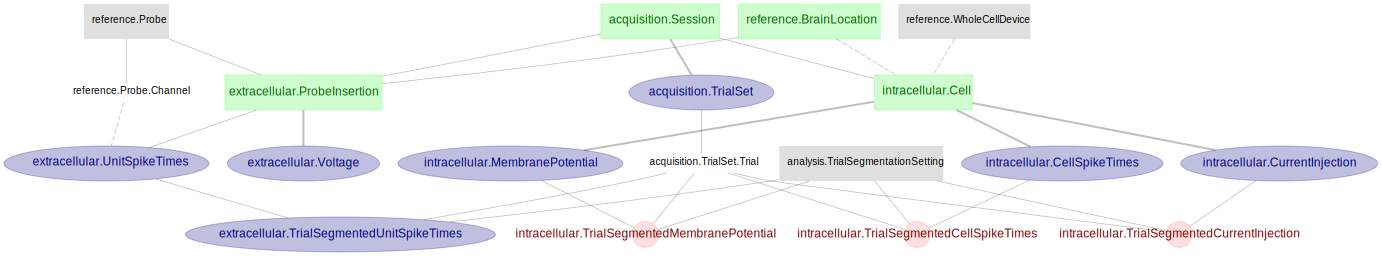

In [8]:
(dj.Diagram(extracellular) - 1) + (dj.Diagram(intracellular) - 1)

As an example, `intracellular.CellSpikeTimes` table contains information about the intracellular recording of each cell, and the associated spike trains (in the form of spike times).

In [9]:
intracellular.CellSpikeTimes() * intracellular.Cell * reference.BrainLocation

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,cell_id a string identifying the cell in which this intracellular recording is concerning,brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,"spike_times (s) time of each spike, with respect to the start of session",cell_type,cell_depth (um),device_name,brain_location_full_name
anm284530,2015-07-01 00:00:00,Whole_cell_105_regular,cell_105,ALM,N/A,N/A,left,=BLOB=,Pyr,235.0,Multiclamp 700B,N/A
anm284530,2015-07-01 00:00:00,Whole_cell_106_regular,cell_106,ALM,N/A,N/A,left,=BLOB=,Pyr,280.0,Multiclamp 700B,N/A
anm284530,2015-07-02 00:00:00,Whole_cell_108_regular,cell_108,ALM,N/A,N/A,left,=BLOB=,Pyr,517.0,Multiclamp 700B,N/A
anm284530,2015-07-03 00:00:00,Whole_cell_109_regular,cell_109,ALM,N/A,N/A,left,=BLOB=,Pyr,582.0,Multiclamp 700B,N/A
anm284530,2015-07-03 00:00:00,Whole_cell_110_regular,cell_110,ALM,N/A,N/A,left,=BLOB=,Pyr,611.0,Multiclamp 700B,N/A
anm287242,2015-08-05 00:00:00,Whole_cell_131_regular,cell_131,ALM,N/A,N/A,left,=BLOB=,Pyr,293.0,Multiclamp 700B,N/A
anm287242,2015-08-06 00:00:00,Whole_cell_133_regular,cell_133,ALM,N/A,N/A,left,=BLOB=,Pyr,620.0,Multiclamp 700B,N/A


As an example, `extracellular.UnitSpikeTimes` table contains information about each and every sorted units and their associated spike trains (in the form of unit spike times).

In [10]:
extracellular.UnitSpikeTimes * extracellular.ProbeInsertion

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,probe_name String naming probe model,channel_counts number of channels in the probe,brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,unit_id,channel_id id of a channel on the probe,"spike_times (s) time of each spike, with respect to the start of session","unit_cell_type e.g. cell-type of this unit (e.g. wide width, narrow width spiking)","unit_spike_width (ms) spike width of this unit, from bottom peak to next positive peak or time point spike terminates",unit_depth (mm),spike_waveform waveform(s) of each spike at each spike time (spike_time x waveform_timestamps)
anm319313,2016-01-05 00:00:00,HI72_010516,A2x32-8mm-25-250-165,64,ALM,N/A,N/A,left,0,11,=BLOB=,N/A,0.68,953.248,=BLOB=
anm319313,2016-01-05 00:00:00,HI72_010516,A2x32-8mm-25-250-165,64,ALM,N/A,N/A,left,1,11,=BLOB=,N/A,0.64,925.127,=BLOB=
anm319313,2016-01-05 00:00:00,HI72_010516,A2x32-8mm-25-250-165,64,ALM,N/A,N/A,left,2,11,=BLOB=,N/A,0.8,878.272,=BLOB=
anm319313,2016-01-05 00:00:00,HI72_010516,A2x32-8mm-25-250-165,64,ALM,N/A,N/A,left,3,11,=BLOB=,N/A,0.68,803.031,=BLOB=
anm319313,2016-01-05 00:00:00,HI72_010516,A2x32-8mm-25-250-165,64,ALM,N/A,N/A,left,4,11,=BLOB=,N/A,0.64,801.097,=BLOB=
anm319313,2016-01-05 00:00:00,HI72_010516,A2x32-8mm-25-250-165,64,ALM,N/A,N/A,left,5,11,=BLOB=,N/A,0.84,621.366,=BLOB=
anm319313,2016-01-05 00:00:00,HI72_010516,A2x32-8mm-25-250-165,64,ALM,N/A,N/A,left,6,11,=BLOB=,N/A,0.68,623.204,=BLOB=


## Reproduced analysis and figures

The following sections outline the steps to search and extract relevant data, perform some level of data processing, restructuring, and plot for several figures from the two studies.

## Inagaki 2019 - Reproduce Figure 2 - whole-cell

Figure 2c depicts the no-photostim trial-averaged spike PSTH (top) and membrane potential (bottom) for a representative cell. 

Figure 2b shows the cell's membrane potential of several individual trials, all time-locked to `go cue`

To reproduce this figure, several steps are taken:
1. Select a representative cell (here we picked cell 96)
2. Specify trial selection criteria: ipsi vs. contra trial, no photostim
3. Extract ***trial-segmented membrane potential*** and ***trial-segmented spike times***, categorized by ipsi vs. contra trials
4. Plot individual trial membrane potential, trial-averaged membrane potential and spike PSTH

In [11]:
# Select a particuclar setting defining how to segment out information per trial, 
# including the definition of even for alignment
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'cue_start',
                                                      'pre_stim_duration': 4,
                                                      'post_stim_duration': 2}).fetch1()

First, we specify trial-restrictor: ipsi vs. contra trials, no photostim

In [12]:
nostim_contra_trials = {'trial_type': 'lick right', 'trial_response': 'correct', 'trial_stim_present': False}
nostim_ipsi_trials = {'trial_type': 'lick left', 'trial_response': 'correct', 'trial_stim_present': False}

Next, we pick a representative cell - cell 96

In [13]:
cell_96 = (intracellular.Cell & {'cell_id': 'cell_96'}
           & (acquisition.Session.ExperimentType & {'experiment_type': 'regular'})).fetch('KEY')

Then we extract the recorded Membrane Potential of this cell, separate into **contra** and **ipsi** trials

In [14]:
# contra trials
contra_trial_mp, contra_trial_mp_wo_spike = (intracellular.TrialSegmentedMembranePotential & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_contra_trials)).fetch('segmented_mp', 'segmented_mp_wo_spike')
# ipsi trials
ipsi_trial_mp, ipsi_trial_mp_wo_spike = (intracellular.TrialSegmentedMembranePotential & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_ipsi_trials)).fetch('segmented_mp', 'segmented_mp_wo_spike')

Similarly, we extract spike times

In [15]:
# contra trials
contra_trial_spiketimes = (intracellular.TrialSegmentedCellSpikeTimes & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_contra_trials)).fetch('segmented_spike_times')
# ipsi trials
ipsi_trial_spiketimes = (intracellular.TrialSegmentedCellSpikeTimes & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_ipsi_trials)).fetch('segmented_spike_times')

We then perform several processing, data conditioning steps

In [16]:
# Query event times (e.g. sample-start, delay-start, etc.)
events, event_times = (analysis.RealignedEvent.RealignedEventTime & seg_param_key & cell_96 &
                      (acquisition.TrialSet.Trial & [{'trial_response': 'correct'},
                                                     {'trial_response': 'incorrect'}])).fetch('trial_event',
                                                                                              'realigned_event_time')
# Calculate mean event times across trials
mean_event_times = {name: np.nanmedian([t for n, t in zip(events, event_times) if n == name]) for name in set(events)}

In [17]:
# Construct time vector
fs = intracellular.MembranePotential.fetch('membrane_potential_sampling_rate', limit=1).item()
timestamps = np.arange(-1 * float(seg_param_key['pre_stim_duration']) * fs,
                       float(seg_param_key['post_stim_duration']) * fs + 1) / fs

In [18]:
# Compute spike histogram 
bin_counts = 100
contra_trial_spikecounts, contra_edges = np.histogram(np.hstack(contra_trial_spiketimes).flatten(), 
                                                      bins=bin_counts, range=(timestamps[0], timestamps[-1]))
contra_trial_spikerate = contra_trial_spikecounts / np.diff(contra_edges) / contra_trial_spiketimes.size

ipsi_trial_spikecounts, ipsi_edges = np.histogram(np.hstack(ipsi_trial_spiketimes).flatten(), 
                                                      bins=bin_counts, range=(timestamps[0], timestamps[-1]))
ipsi_trial_spikerate = ipsi_trial_spikecounts / np.diff(ipsi_edges) / ipsi_trial_spiketimes.size

### Plot Figure 2c

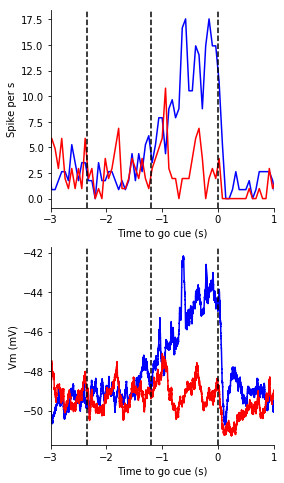

In [19]:
# Reproduce Figure 2c 
fig2b, axs = plt.subplots(2, 1, figsize=(4, 8))

axs[0].plot(contra_edges[1:], contra_trial_spikerate, 'b')
axs[0].plot(ipsi_edges[1:], ipsi_trial_spikerate, 'r')
axs[0].set_ylabel('Spike per s')

axs[1].plot(timestamps, np.vstack(contra_trial_mp_wo_spike).mean(axis=0), 'b')
axs[1].plot(timestamps, np.vstack(ipsi_trial_mp_wo_spike).mean(axis=0), 'r')
axs[1].set_ylabel('Vm (mV)')

for ax in axs:
# event markers
    for e in ('sampling_start', 'delay_start', 'cue_start'):
        ax.axvline(x=mean_event_times[e], linestyle='--', color='k')

    # Hide the spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim((-3, 1));
    ax.set_xlabel('Time to go cue (s)')

Now we plot several single-trial membrane potential, overlayed by the lick traces of that trial

In [20]:
# Single trial - correct lick right trials (contra-trial) #2 ~ 7
contra_trial_lick_right = (behavior.TrialSegmentedLickTrace & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_contra_trials)).fetch('segmented_lick_right_on')

### Plot Figure 2b

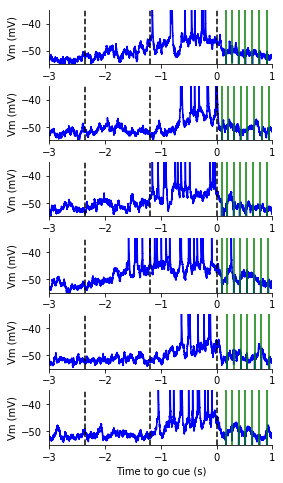

In [21]:
# Reproduce Figure 2b
trials = np.arange(1,7)
fig2c, axs = plt.subplots(trials.size, 1, figsize=(4, 8))
fig2c.subplots_adjust(hspace=0.4)
for ax, tr in zip(axs, trials):
    ax.plot(timestamps, contra_trial_mp[tr], 'b')
    # lick times
    for t in contra_trial_lick_right[tr]:
        ax.axvline(x=t, linestyle='-', color='g')
    # event markers
    for e in ('sampling_start', 'delay_start', 'cue_start'):
        ax.axvline(x=mean_event_times[e], linestyle='--', color='k')
    ax.set_ylabel('Vm (mV)')
    ax.set_ylim((-55, -35))
    ax.set_xlim((-3, 1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
axs[-1].set_xlabel('Time to go cue (s)');

##  Inagaki 2019 - Reproduce Figure 5a - extracellular - fixed-delay

Figure 5a shows the spike raster and PSTH of a representative unit across four trial conditions:
+ Control (no-stim) trials with correct response
+ Control (no-stim) trials with incorrect response
+ Perturbed (photostim) trials with correct response
+ Perturbed (photostim) trials with incorrect response

Each with trials categorized in ipsi vs. contra trials

To reproduce this figure, we will build several helper functions: 
+ `query_unit_segmented_spiketimes()` - for any specified session, unit, and trial criteria, extract the trial-segmented unit spike times, categorized in ipsi and contra trial groups
+ `plot_spike_raster_and_histogram()` - given spike times in ipsi and contra trial groups, plot spike raster and PSTH 

In [22]:
# query trial-segmented spiketimes for a single unit in the one specifed session
def query_unit_segmented_spiketimes(sess_key, unit, trial_key, seg_param_key):
    data_keys = (extracellular.TrialSegmentedUnitSpikeTimes & sess_key & {'unit_id': unit} & seg_param_key &
                 ((acquisition.TrialSet.Trial & trial_key))).fetch('KEY')
    return pd.DataFrame([dict(**dict(zip(*(analysis.RealignedEvent.RealignedEventTime & k).fetch('trial_event', 'realigned_event_time'))), 
                 segmented_spike_times=(extracellular.TrialSegmentedUnitSpikeTimes & k).fetch1(
                     'segmented_spike_times')) for k in data_keys])

In [23]:
def plot_spike_raster_and_histogram(contra_spike_times, ipsi_spike_times, axes, ax_title='', bin_counts=200, xlim=(-1.5, 3), shade_bar=False):
    # get event timing
    events = ['sampling_start', 'delay_start', 'cue_start']
    event_times = np.around([np.median(np.hstack([ipsi_spike_times[e], contra_spike_times[e]])) for e in events if e in ipsi_spike_times], 4)
    
    # restructure data for spike raster  
    ipsi_c_trial_idx, ipsi_c_spike_times = zip(*((np.full_like(r, ri), r)
                                            for ri, r in enumerate(r for r in ipsi_spike_times.segmented_spike_times if len(r) != 0)))
    ipsi_c_trial_idx = np.hstack(ipsi_c_trial_idx)
    ipsi_c_spike_times = np.hstack(ipsi_c_spike_times)    
    
    contra_c_trial_idx, contra_c_spike_times = zip(*((np.full_like(r, ri), r)
                                            for ri, r in enumerate(r for r in contra_spike_times.segmented_spike_times if len(r) != 0)))
    contra_c_trial_idx = np.hstack(contra_c_trial_idx)
    contra_c_spike_times = np.hstack(contra_c_spike_times)  
    
    # spiketime histogram
    time_range = (float(-1*seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration']))
    
    ipsi_spk_counts, ipsi_edges = np.histogram(np.hstack([r.segmented_spike_times
                                                          for _, r in ipsi_spike_times.iterrows()]),
                                               bins=bin_counts,
                                               range=(time_range[0], time_range[-1]))
    ipsi_spk_rates = ipsi_spk_counts / np.diff(ipsi_edges) / ipsi_spike_times.segmented_spike_times.shape[0]
    
    contra_spk_counts, contra_edges = np.histogram(np.hstack([r.segmented_spike_times
                                                          for _, r in contra_spike_times.iterrows()]),
                                                   bins=bin_counts,
                                                   range=(time_range[0], time_range[-1]))
    contra_spk_rates = contra_spk_counts / np.diff(contra_edges) / contra_spike_times.segmented_spike_times.shape[0]
   
    # plot
    # spike raster
    ax_top = axes[0]
    ax_top.plot(contra_c_spike_times, contra_c_trial_idx , '|b', markersize=2)
    ax_top.plot(ipsi_c_spike_times, ipsi_c_trial_idx + contra_c_trial_idx.max(), '|r', markersize=2)
    # event markers
    for e in event_times:
        ax_top.axvline(x=e, linestyle='--', color='k')
    ax_top.set_xticklabels([])
    ax_top.set_yticklabels([])
    ax_top.set_title(ax_title)
    ax_top.set_xlim(xlim);
    
    # spike histogram
    ax_bot = axes[1]
    ax_bot.plot(contra_edges[1:], contra_spk_rates, 'b')
    ax_bot.plot(ipsi_edges[1:], ipsi_spk_rates, 'r')
    for e in event_times:
        ax_bot.axvline(x=e, linestyle='--', color='k')
    ax_bot.set_xlim(xlim);
    ax_bot.set_xlabel('Time to go cue (s)')
    ax_bot.set_ylabel('Spikes per s')
    
    # shade-bar for photostim
    if shade_bar:
        for ax in axes:
            ax.axvspan(event_times[1], event_times[1] + 0.6, alpha = 0.3, color = 'royalblue')
    
    # Hide the spines
    ax_top.spines['right'].set_visible(False)
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['left'].set_visible(False)
    ax_top.spines['bottom'].set_visible(False)
    ax_bot.spines['right'].set_visible(False)
    ax_bot.spines['top'].set_visible(False)

### Define trial-restrictor for 3 criteria:
1. trial-response: correct/incorrect 
2. trial-type: lick-left/lick-right
3. photostim: stim/nostim

In [24]:
correct_contra_trial_ctrl  = {'trial_type': 'lick right', 'trial_response': 'correct', 'trial_stim_present': False, 'trial_is_good': True}
correct_contra_trial_stim  = {'trial_type': 'lick right', 'trial_response': 'correct', 'trial_stim_present': True, 'trial_is_good': True}
incorrect_contra_trial_ctrl  = {'trial_type': 'lick right', 'trial_response': 'incorrect', 'trial_stim_present': False, 'trial_is_good': True}
incorrect_contra_trial_stim  = {'trial_type': 'lick right', 'trial_response': 'incorrect', 'trial_stim_present': True, 'trial_is_good': True}

correct_ipsi_trial_ctrl  = {'trial_type': 'lick left', 'trial_response': 'correct', 'trial_stim_present': False, 'trial_is_good': True}
correct_ipsi_trial_stim  = {'trial_type': 'lick left', 'trial_response': 'correct', 'trial_stim_present': True, 'trial_is_good': True}
incorrect_ipsi_trial_ctrl  = {'trial_type': 'lick left', 'trial_response': 'incorrect', 'trial_stim_present': False, 'trial_is_good': True}
incorrect_ipsi_trial_stim  = {'trial_type': 'lick left', 'trial_response': 'incorrect', 'trial_stim_present': True, 'trial_is_good': True}

In [25]:
def get_sess_spiketimes(sess_key, unit_num):
    return dict(correct_ctrl={k: query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                              unit=unit_num,
                                                                              trial_key=trial_k,
                                                                              seg_param_key=seg_param_key) 
                              for k, trial_k in zip(('contra', 'ipsi'), (correct_contra_trial_ctrl, correct_ipsi_trial_ctrl))},
                incorrect_ctrl={k: query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                                       unit=unit_num,
                                                                                       trial_key=trial_k,
                                                                                       seg_param_key=seg_param_key) 
                                for k, trial_k in zip(('contra', 'ipsi'), (incorrect_contra_trial_ctrl, incorrect_ipsi_trial_ctrl))},
                correct_stim={k: query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                              unit=unit_num,
                                                                              trial_key=trial_k,
                                                                              seg_param_key=seg_param_key) 
                              for k, trial_k in zip(('contra', 'ipsi'), (correct_contra_trial_stim, correct_ipsi_trial_stim))},
                incorrect_stim={k: query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                                unit=unit_num,
                                                                                trial_key=trial_k,
                                                                                seg_param_key=seg_param_key) 
                                for k, trial_k in zip(('contra', 'ipsi'), (incorrect_contra_trial_stim, incorrect_ipsi_trial_stim))}) 

### Plots for example units - spike raster and PSTH - Fig 5a

Here we pick ***HI127_031617*** as the representative session, with unit ***24***

In [26]:
sess_spiketimes = get_sess_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI127_031617'}, 
                                      unit_num=24)

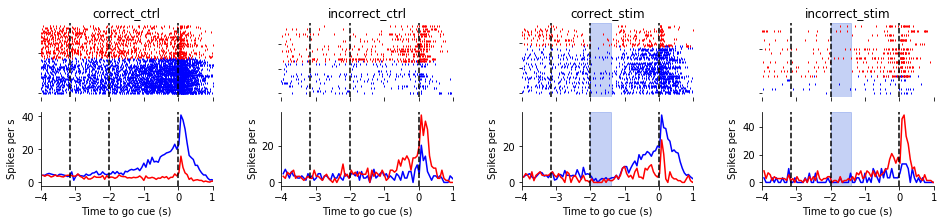

In [27]:
bin_counts = 100
unit_count = len(sess_spiketimes)
fig, axs = plt.subplots(2, unit_count, figsize=(16, 3))
fig.subplots_adjust(wspace=0.4)

for ax, k, is_stim in zip(axs.T, sess_spiketimes.keys(), (False, False, True, True)):
    plot_spike_raster_and_histogram(sess_spiketimes[k]['contra'], sess_spiketimes[k]['ipsi'], 
                                    axes=ax, ax_title=k, bin_counts=bin_counts,
                                    xlim=(-4, 1), shade_bar=is_stim)

##  Inagaki 2018 - Reproduce Figure 4 a,b,c 
### Fixed Delay Tactile Task (1.2s) and Auditory Task (1.2s or 2s)

This figure features the neural activity in response to 3 different task categories:
+ Tactile task with 1.2s delay duration
+ Auditory task with 1.2s delay duration
+ Auditory task with 2s delay duration

All without optogenetic perturbations and groups into **ipsi** vs. **contra** trials

Leveraging the 2 helper functions above, now we only need to specify the queries for those 3 task conditions appropriately. 

In [28]:
# Specify segmentation setting to align to "cue-onset" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'cue_start',
                                                      'pre_stim_duration': 4,
                                                      'post_stim_duration': 2}).fetch1()

In [29]:
# Trial-restrictor to all good trials, regarless of correct/incorrect response or photostim status
contra_trial  = {'trial_type': 'lick right', 'trial_is_good': True}
ipsi_trial  = {'trial_type': 'lick left', 'trial_is_good': True}

#### Restrict to extracellular sessions of type "Tactile Task" and "Auditory Task"

With this, we will group all tactile-task sessions in `tactile_ec_sess` and auditory-task sessions in `auditory_ec_sess`

In [30]:
tactile_ec_sess = (acquisition.Session 
                & (acquisition.Session.ExperimentType & 'experiment_type="Tactile Task"').fetch('KEY')
                & (acquisition.Session.ExperimentType & 'experiment_type="extracellular"').fetch('KEY'))
auditory_ec_sess = (acquisition.Session 
                & (acquisition.Session.ExperimentType & 'experiment_type="Auditory Task"').fetch('KEY')
                & (acquisition.Session.ExperimentType & 'experiment_type="extracellular"').fetch('KEY'))

Define a convenient function to evoke `query_unit_segmented_spiketimes()` for different trial condition (e.g. ipsi, contra) and task type (e.g. tactile, auditory)

In [31]:
def get_sess_spiketimes_alltrials(sess_key, unit_num, contra, ipsi):
    return {f'{s_id["session_id"]}_{u_id}': {k: query_unit_segmented_spiketimes(sess_key=s_id,
                                                                  unit=u_id,
                                                                  trial_key=trial_k,
                                                                  seg_param_key=seg_param_key) 
                               for k, trial_k in zip(('contra', 'ipsi'), (contra, ipsi))} 
            for s_id, u_id in zip(sess_key, unit_num)}

### Tactile Task - Delay 1.2s - plot 6 sample units (randomly selected)

At this point, for sessions of **tactile task**, we need to specify one more trial condition, `delay_duration`, to limit to the trials with delay duration of interest (here **1.2 sec**)

In [32]:
sess = (tactile_ec_sess & (acquisition.TrialSet.Trial & 'delay_duration = 1.2')).fetch('KEY')[0:6]
tactile_short_spiketimes = get_sess_spiketimes_alltrials(sess_key=sess, unit_num=np.random.randint(len(sess), size=len(sess)),
                                                         contra=contra_trial, ipsi=ipsi_trial)

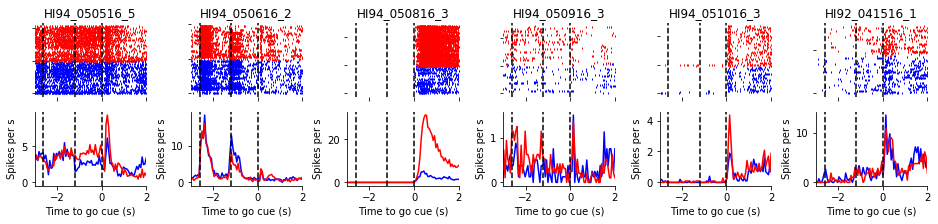

In [33]:
bin_counts = 100
unit_count = len(tactile_short_spiketimes)
fig, axs = plt.subplots(2, unit_count, figsize=(16, 3))
fig.subplots_adjust(wspace=0.4)

for ax, k in zip(axs.T, tactile_short_spiketimes.keys()):
    plot_spike_raster_and_histogram(tactile_short_spiketimes[k]['contra'], tactile_short_spiketimes[k]['ipsi'], 
                                    axes=ax, ax_title=k, bin_counts=bin_counts, xlim=(-3, 2))

### Auditory Task - Delay 1.2s - plot 6 sample units

Similar to above, with **auditory task**

In [34]:
sess = (auditory_ec_sess & (acquisition.TrialSet.Trial & 'delay_duration = 1.2')).fetch('KEY')[4:11]
auditory_short_spiketimes = get_sess_spiketimes_alltrials(sess_key=sess, unit_num=np.random.randint(len(sess), size=len(sess)),
                                                          contra=dict(contra_trial, delay_duration=1.2),
                                                         ipsi=dict(ipsi_trial, delay_duration=1.2))

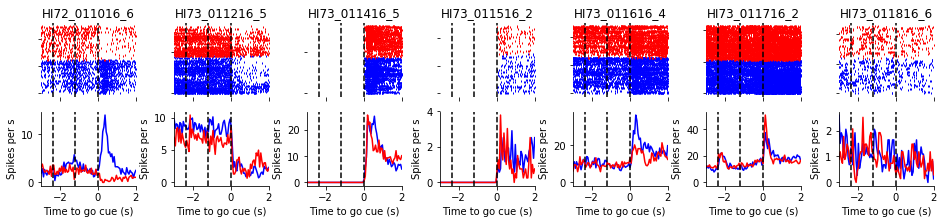

In [35]:
bin_counts = 100
unit_count = len(auditory_short_spiketimes)
fig, axs = plt.subplots(2, unit_count, figsize=(16, 3))
fig.subplots_adjust(wspace=0.4)

for ax, k in zip(axs.T, auditory_short_spiketimes.keys()):
    plot_spike_raster_and_histogram(auditory_short_spiketimes[k]['contra'], auditory_short_spiketimes[k]['ipsi'], 
                                    axes=ax, ax_title=k, bin_counts=bin_counts, xlim=(-3, 2))

### Auditory Task - Delay 2s - plot 6 sample units
Similar to above, with delay duration of **2 sec**

In [36]:
sess = (auditory_ec_sess & (acquisition.TrialSet.Trial & 'delay_duration = 2')).fetch('KEY')[16:22]
auditory_long_spiketimes = get_sess_spiketimes_alltrials(sess_key=sess, unit_num=np.random.randint(len(sess), size=len(sess)),
                                                          contra=dict(contra_trial, delay_duration=2),
                                                         ipsi=dict(ipsi_trial, delay_duration=2))

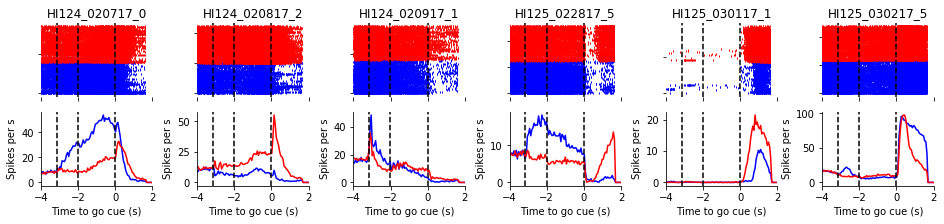

In [37]:
bin_counts = 100
unit_count = len(auditory_long_spiketimes)
fig, axs = plt.subplots(2, unit_count, figsize=(16, 3))
fig.subplots_adjust(wspace=0.4)

for ax, k in zip(axs.T, auditory_long_spiketimes.keys()):
    plot_spike_raster_and_histogram(auditory_long_spiketimes[k]['contra'], auditory_long_spiketimes[k]['ipsi'], 
                                    axes = ax, ax_title=k, bin_counts=bin_counts, xlim=(-4, 2))

## Inagaki 2019 - Reproduce Extended Data Figure 8k - extracellular - fixed 2 second delay
#### Display spike rates and PSTH for trials with fixed delay duration of 2 seconds

This figure is relatively similar to Figure 5a in Inagaki 2019 paper plotted above. However, this figure expands onto neural response comparision between with and without optogenetic perturbations in fixed 2-second delay task.

In [38]:
# Specify segmentation setting to align to "delay-onset" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'delay_start',
                                                      'pre_stim_duration': 2,
                                                      'post_stim_duration': 4}).fetch1()

### Define query for trial-segmented spiketimes for a single unit in the one specifed session:
1. restrict stimulation power > 0.05 mW
2. delay duration of 2 sec only

In [39]:
def query_unit_segmented_spiketimes(sess_key, unit, trial_key, seg_param_key):
    data_keys = (extracellular.TrialSegmentedUnitSpikeTimes & sess_key & {'unit_id': unit} & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key & 'delay_duration=2') &
                 (stimulation.TrialPhotoStimParam & ['photo_stim_power is NULL', 'photo_stim_power > 0.05'])).fetch('KEY')
    return pd.DataFrame([dict(**dict(zip(*(analysis.RealignedEvent.RealignedEventTime & k).fetch('trial_event', 'realigned_event_time'))), 
                              segmented_spike_times=(extracellular.TrialSegmentedUnitSpikeTimes & k).fetch1('segmented_spike_times'),
                              delay_duration=(acquisition.TrialSet.Trial & k).fetch1('delay_duration')) 
                         for k in data_keys])

### Plots for example units

Example unit ***11***

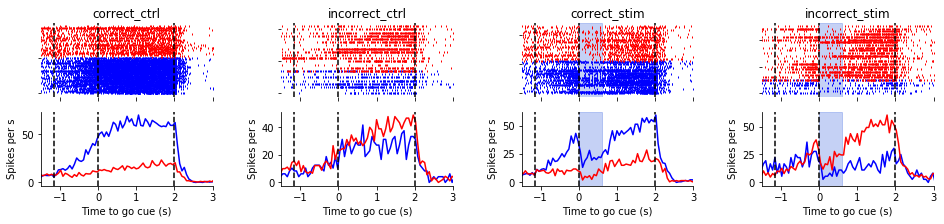

In [40]:
sess_spiketimes = get_sess_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI152_060218'},
                                      unit_num=11)
# spike raster and histogram - Fig 6 - fixed delay duration of 2s
bin_counts = 100
unit_count = len(sess_spiketimes)
fig, axs = plt.subplots(2, unit_count, figsize=(16, 3))
fig.subplots_adjust(wspace=0.4)

for ax, k, is_stim in zip(axs.T, sess_spiketimes.keys(), (False, False, True, True)):
    plot_spike_raster_and_histogram(sess_spiketimes[k]['contra'], sess_spiketimes[k]['ipsi'], 
                                    axes = ax, ax_title=k, bin_counts=bin_counts, shade_bar=is_stim)

Example unit ***21***

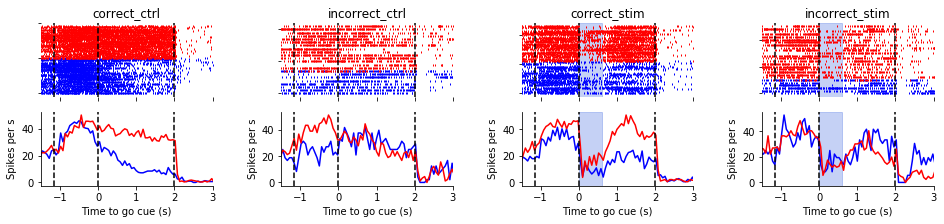

In [41]:
sess_spiketimes = get_sess_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI152_060218'},
                                      unit_num=21)
# spike raster and histogram - Fig 6 - fixed delay duration of 2s
bin_counts = 100
unit_count = len(sess_spiketimes)
fig, axs = plt.subplots(2, unit_count, figsize=(16, 3))
fig.subplots_adjust(wspace=0.4)

for ax, k, is_stim in zip(axs.T, sess_spiketimes.keys(), (False, False, True, True)):
    plot_spike_raster_and_histogram(sess_spiketimes[k]['contra'], sess_spiketimes[k]['ipsi'], 
                                    axes = ax, ax_title=k, bin_counts=bin_counts, shade_bar=is_stim)

## Inagaki 2019 - Reproduce Extended Data Figure 8k - extracellular - random delay

This next set of figures presents the spiking pattern from the same unit above, in response to varying delay duration, limited to control trials only.

Again, several steps are taken to reproduce the figure:

1. Extract trials with different delay_duration 
2. Sort trials based on delay_duration
3. Display spike raster and PSTH 

Let's construct several helper functions as above, with a few minor tweaks (namely the sorting of trials based on delay duration)

In [46]:
def plot_spike_raster_and_histogram(contra_spike_times, ipsi_spike_times, axes, ax_title='', bin_counts=200):
    # get event timing
    events = ['sampling_start', 'delay_start'] 
    event_times = np.around([np.median(np.hstack([ipsi_spike_times[e], contra_spike_times[e]])) for e in events], 4)
    
    # restructure data for spike raster  
    ipsi_c_trial_idx, ipsi_c_spike_times, ipsi_c_cue_start = zip(*((np.full_like(r[1].segmented_spike_times, r_idx),
                                                  r[1].segmented_spike_times, 
                                                  np.full_like(r[1].segmented_spike_times, r[1].cue_start))
                                            for r_idx, r in enumerate(ipsi_spike_times.iterrows())))                                        
    ipsi_c_trial_idx = np.hstack(ipsi_c_trial_idx)
    ipsi_c_spike_times = np.hstack(ipsi_c_spike_times)  
    ipsi_c_cue_start = np.hstack(ipsi_c_cue_start)
    
    contra_c_trial_idx, contra_c_spike_times, contra_c_cue_start = zip(*((np.full_like(r[1].segmented_spike_times, r_idx),
                                                  r[1].segmented_spike_times, 
                                                  np.full_like(r[1].segmented_spike_times, r[1].cue_start))
                                            for r_idx, r in enumerate(contra_spike_times.iterrows())))                                        
    contra_c_trial_idx = np.hstack(contra_c_trial_idx)
    contra_c_spike_times = np.hstack(contra_c_spike_times)  
    contra_c_cue_start = np.hstack(contra_c_cue_start) 
    
    # spiketime histogram
    time_range = (-2, 4) 

    # select only spike times prior to go-cue (cue_start) to compute the PSTH
    ipsi_spk_rates = np.nanmean(np.vstack([next(map(lambda x: np.where(x[1][1:] < r.cue_start, x[0]/np.diff(x[1]), np.nan), 
                                                    [np.histogram(r.segmented_spike_times,
                                                                  bins=bin_counts, range=(time_range[0], time_range[-1]))]))
                                           for _, r in ipsi_spike_times.iterrows()]), axis=0)
    ipsi_edges = np.histogram_bin_edges(ipsi_spike_times.segmented_spike_times[0],
                                        bins=bin_counts, range=(time_range[0], time_range[-1]))
    
    contra_spk_rates = np.nanmean(np.vstack([next(map(lambda x: np.where(x[1][1:] < r.cue_start, x[0]/np.diff(x[1]), np.nan), 
                                                [np.histogram(r.segmented_spike_times,
                                                              bins=bin_counts, range=(time_range[0], time_range[-1]))]))
                                       for _, r in contra_spike_times.iterrows()]), axis=0)
    contra_edges = np.histogram_bin_edges(contra_spike_times.segmented_spike_times[0],
                                        bins=bin_counts, range=(time_range[0], time_range[-1]))
    
    # plot
    # spike raster
    ax_top = axes[0]
    ax_top.plot(contra_c_spike_times, contra_c_trial_idx , '|b', markersize=2)
    ax_top.plot(ipsi_c_spike_times, ipsi_c_trial_idx + contra_c_trial_idx.max(), '|r', markersize=2)
    # cue-start times
    ax_top.plot(contra_c_cue_start, contra_c_trial_idx , '|k', markersize=1)
    ax_top.plot(ipsi_c_cue_start, ipsi_c_trial_idx + contra_c_trial_idx.max(), '|k', markersize=1)
    # event markers
    for e in event_times:  
        ax_top.axvline(x=e, linestyle='--', color='k')
    ax_top.set_xticklabels([])
    ax_top.set_yticklabels([])
    ax_top.set_ylabel(ax_title)
    ax_top.set_xlim(time_range);
    
    # spike histogram
    ax_bot = axes[1]
    ax_bot.plot(contra_edges[1:], contra_spk_rates, 'b')
    ax_bot.plot(ipsi_edges[1:], ipsi_spk_rates, 'r')
    for e in event_times:
        ax_bot.axvline(x=e, linestyle='--', color='k')
    ax_bot.set_xlim(time_range);
    ax_bot.set_xlabel('Time from delay onset (s)')
    ax_bot.set_ylabel('Spikes per s')
    
    # Hide the spines
    ax_top.spines['right'].set_visible(False)
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['left'].set_visible(False)
    ax_top.spines['bottom'].set_visible(False)
    ax_bot.spines['right'].set_visible(False)
    ax_bot.spines['top'].set_visible(False)

### Define query for trial-segmented spiketimes for a single unit in the one specifed session:
1. restrict stimulation power > 0.05 mW
2. query also the `delay_duration`

In [43]:
# get trial-segmented spiketimes for a single unit in the one specifed session - get also delay_duration and restrict stim_power>0.05
def query_unit_segmented_spiketimes(sess_key, unit, trial_key, seg_param_key):
    data_keys = (extracellular.TrialSegmentedUnitSpikeTimes & sess_key & {'unit_id': unit} & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key) &
                 (stimulation.TrialPhotoStimParam & ['photo_stim_power is NULL', 'photo_stim_power > 0.05'])).fetch('KEY')
    return pd.DataFrame([dict(**dict(zip(*(analysis.RealignedEvent.RealignedEventTime & k).fetch('trial_event', 'realigned_event_time'))), 
                              segmented_spike_times=(extracellular.TrialSegmentedUnitSpikeTimes & k).fetch1('segmented_spike_times'),
                              delay_duration=(acquisition.TrialSet.Trial & k).fetch1('delay_duration')) 
                         for k in data_keys])

# shift to delay-onset and add a column with sorted trial idx based on delay-duration
def conditioning(data):
    data = data.sort_values(by='delay_duration', ascending=False)
    return data

def get_sess_sorted_spiketimes(sess_key, unit_num):
    return dict(correct_ctrl={k: conditioning(query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                              unit=unit_num,
                                                                              trial_key=trial_k,
                                                                              seg_param_key=seg_param_key)) 
                              for k, trial_k in zip(('contra', 'ipsi'), (correct_contra_trial_ctrl, correct_ipsi_trial_ctrl))},
                incorrect_ctrl={k: conditioning(query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                                       unit=unit_num,
                                                                                       trial_key=trial_k,
                                                                                       seg_param_key=seg_param_key)) 
                                for k, trial_k in zip(('contra', 'ipsi'), (incorrect_contra_trial_ctrl, incorrect_ipsi_trial_ctrl))},
                correct_stim={k: conditioning(query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                              unit=unit_num,
                                                                              trial_key=trial_k,
                                                                              seg_param_key=seg_param_key)) 
                              for k, trial_k in zip(('contra', 'ipsi'), (correct_contra_trial_stim, correct_ipsi_trial_stim))},
                incorrect_stim={k: conditioning(query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                                unit=unit_num,
                                                                                trial_key=trial_k,
                                                                                seg_param_key=seg_param_key)) 
                                for k, trial_k in zip(('contra', 'ipsi'), (incorrect_contra_trial_stim, incorrect_ipsi_trial_stim))}) 

### Plots for example units

Example unit ***11***

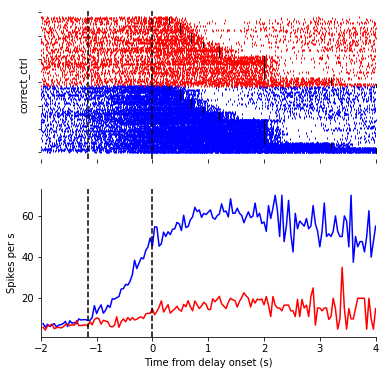

In [47]:
sess_spiketimes = get_sess_sorted_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI152_060218'},
                                      unit_num=11)
bin_counts = 150
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
plot_spike_raster_and_histogram(sess_spiketimes['correct_ctrl']['contra'], sess_spiketimes['correct_ctrl']['ipsi'], 
                                axes = axs,
                                ax_title='correct_ctrl', bin_counts=bin_counts)

Example unit ***21***

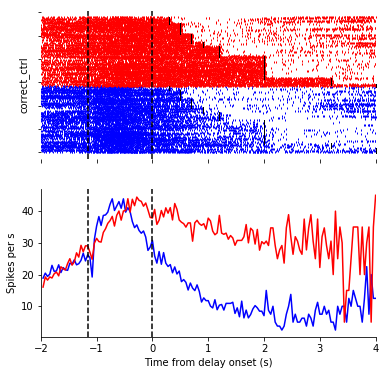

In [48]:
sess_spiketimes = get_sess_sorted_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI152_060218'},
                                      unit_num=21)
bin_counts = 150
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
plot_spike_raster_and_histogram(sess_spiketimes['correct_ctrl']['contra'], sess_spiketimes['correct_ctrl']['ipsi'], 
                                axes = axs,
                                ax_title='correct_ctrl', bin_counts=bin_counts)